<div>
    <img src='../pics/banner.PNG'/>
</div>
<div>
    <img width="10%" height="10%" src='../pics/python-programming.png'/>
    <img src='../pics/miw.PNG'/>
</div>
<div>
    <em>Author: Jeroen Boogaard</em>
</div>

<h2>Imports<h2>

In [42]:
from os import system as sys
sys('pip list | grep django || pip install --upgrade -r requirements.txt')

django-rest-framework         0.1.0
djangorestframework           3.14.0


0

In [43]:
import pandas as pd
import seaborn as sns
import requests
import sqlite3
import numpy as np

<h3>Global variables</h3>

In [44]:
dbName = "../rest_server/medisch_centrum_randstad/db.sqlite3"
tableName = "rest_api_netlify"
url = "http://localhost:8080/medish_centrum_randstad/api/netlify?page=1"
csvFile = "../rest_server/medisch_centrum_randstad/data/data.csv"

<h2>Data Collection</h2>
<img width="30%" height="30%" src="../pics/collect.jpg"/>
<p>De data kan op 3 manieren verzameld worden, dat zijn (op volgorde van kwaliteit van de verzamelingsmethode):</p>

<h3>1. Query SQLite Database</h3>

In [45]:
dbConnection = sqlite3.connect(dbName)

In [46]:
dfFromDB = pd.read_sql_query(f"SELECT * FROM {tableName}", dbConnection)
pd.set_option('display.max_columns', 10)

In [47]:
dbConnection.close()

<h3>2. Collect Data from REST API Server</h3>

In [48]:
page1 = requests.get(url).json()

In [49]:
dfFromAPI = pd.DataFrame(page1['data'])

<h3>3. Collect Data from CSV</h3>

In [50]:
# # pull from .csv not in use atm 
# dfFromCSV = pd.read_csv(csvFile)


<h3>4. Show Data.head</h3>

In [60]:
display(dfFromAPI.head())


,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
0,73.9,185.0,99.7,0.9,0.0,2.4,6.9,73.1
1,86.0,172.0,105.4,1.8,8.1,0.4,4.2,85.0
2,83.3,176.0,111.4,1.1,0.8,4.6,7.5,81.6
3,82.8,164.0,111.4,4.7,11.8,1.0,2.9,81.0
4,78.7,178.0,71.6,1.5,8.3,4.9,5.5,75.0


<h3>5. Data manipulations</h3>

In [52]:
df=dfFromAPI.copy()


<AxesSubplot: >

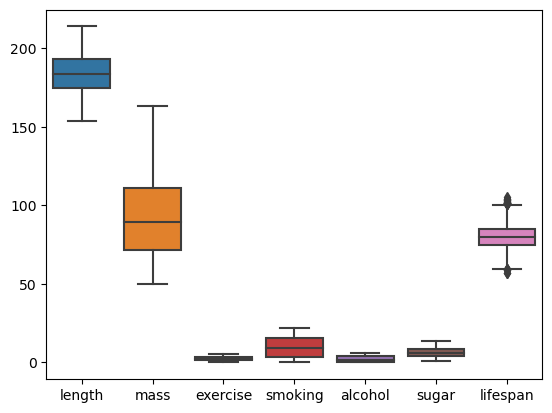

In [53]:
# got any outliers?

sns.boxplot(data=df.iloc[:,1:])
#... alles buiten de lijnen is een outlier. 


In [54]:
# the df will be the old df where we apply changed with a lambda to apply pd.to_numeric where non numbers will be coerced to NaN for those columns were dtype is object.  
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)

# ... change the dtype to float 64
df = df.apply(lambda x: pd.astype('float64') if x.dtype == 'object' else x)


In [55]:
df3=df.copy()  
display(df3.info())

# print(df.isna().sum()), print(df3.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4095 non-null   float64
 1   length    4093 non-null   float64
 2   mass      4094 non-null   float64
 3   exercise  4095 non-null   float64
 4   smoking   4096 non-null   float64
 5   alcohol   4094 non-null   float64
 6   sugar     4095 non-null   float64
 7   lifespan  4094 non-null   float64
dtypes: float64(8)
memory usage: 256.1 KB


None

In [56]:
df3_contains_NaN = df3.loc[df3.isna().any(axis=1)]

<3> BMI wil be generated before we clip on |std*2| to prevent data loss and for cases where length is extreme in one direction and mass in the other but under |std*2| leading to an extreme in bmi over |std*2| </3>

In [57]:
# New Feature BMI (kg/m^2)
df3['bmi'] = df['mass']/(df['length']/100)**2

In [58]:
print(df3.isna().sum())
print(df3.isnull().sum())

genetic     1
length      3
mass        2
exercise    1
smoking     0
alcohol     2
sugar       1
lifespan    2
bmi         5
dtype: int64
genetic     1
length      3
mass        2
exercise    1
smoking     0
alcohol     2
sugar       1
lifespan    2
bmi         5
dtype: int64


In [59]:
# clip of the 

# Computing IQR
Q1 = df3.quantile(0.25)
Q3 = df3.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(Q3*1.5)

df3 = df3.clip(lower=mean-1.5*IQR, upper=mean+1.5*IQR, axis=1)
display (df3)

genetic      77.600000
length      175.000000
mass         71.500000
exercise      1.500000
smoking       3.300000
alcohol       0.600000
sugar         4.400000
lifespan     75.000000
bmi          20.933229
Name: 0.25, dtype: float64
genetic     130.050000
length      289.500000
mass        166.312500
exercise      4.800000
smoking      23.850000
alcohol       6.000000
sugar        12.600000
lifespan    127.800000
bmi          49.820527
Name: 0.75, dtype: float64


NameError: name 'mean' is not defined

In [ ]:
# replace NaN with mean


# Compute the mean of each column and replace NaN values with the mean
df3.fillna(df3.mean(), inplace=True)



In [ ]:
# # cutof 2*std not curretly in use. 

# # Compute the mean and standard deviation of each column
# mean = df3.mean()
# print (mean)
# std = df3.std()
# print (std)

# # Replace values more than 2 standard deviations away from the mean
# df3 = df3.clip(lower=mean-2*std, upper=mean+2*std, axis=1)
# display (df3)



In [ ]:
# Connect to SQLite database
dbConnection = sqlite3.connect('../rest_server_new/medisch_centrum_randstad/db.sqlite3')

In [ ]:
df3.to_sql('cleaned_data_3', dbConnection, if_exists='replace', index = False)

In [ ]:
dbConnection.close()